In [1]:
import os
import io
from getpass import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image packages
from PIL import Image, ImageOps

# PySpark packages
from pyspark import SparkContext, SparkConf
from pyspark.ml.image import ImageSchema
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA, StandardScaler
import pyspark.sql.functions as F
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split, udf
from pyspark.ml.linalg import DenseVector, VectorUDT, Vectors

# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [2]:
# Clés AMI pour accès S3
access_key = getpass(prompt="Clé d'accès pour S3") # Clé accès
secret_key = getpass(prompt='Clé secrète pour S3') # Clé secrète

Clé d'accès pour S3 ····················
Clé secrète pour S3 ········································


In [3]:
# Définition des variables d'environnement système pour accès S3
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key

In [4]:
spark = (SparkSession
         .builder # Création d'une SparkSession
         .master('local[1]') # Allocation de cores
         .config('spark.executor.memory', '2g') # Allocation de mémoire aux executors
         .appName('OC-P8') # Nom donné
         .getOrCreate())

In [5]:
# data_url = "s3a://oc-bucket-img/Training-aws/*" # URL du dossier dans S3
data_url = "data/Train-aws/*"

In [6]:
df = spark.read.format("binaryfile").load(data_url) # Lecture des documents (images) contenues dans le dossier

In [7]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [8]:
df.select("path", "content").show(5)

+--------------------+--------------------+
|                path|             content|
+--------------------+--------------------+
|file:/C:/Users/sa...|[FF D8 FF E0 00 1...|
|file:/C:/Users/sa...|[FF D8 FF E0 00 1...|
|file:/C:/Users/sa...|[FF D8 FF E0 00 1...|
|file:/C:/Users/sa...|[FF D8 FF E0 00 1...|
|file:/C:/Users/sa...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+
only showing top 5 rows



In [9]:
# Préprocessing des chemins d'accès => nom du fruit
def cat_extract(path):
    """
    Fonction donnant le nom du dossier indiqué par le chemin path.
    """
    path = os.path.dirname(path)
    return os.path.basename(path)

In [10]:
# Création d'une user-defined function pour extraire le nom du dossier = nom du fruit, pour classifier
path2name = F.udf(lambda x: cat_extract(x))

In [11]:
# Application à nos données par spark
df_prep = df.withColumn("name", path2name("path")).select('name', 'content')
df_prep.printSchema()

root
 |-- name: string (nullable = true)
 |-- content: binary (nullable = true)



In [12]:
# Fonctionnement sous CPU (environnement Spark sous CPU)
from distutils.version import LooseVersion
from tensorflow import keras

if LooseVersion(tf.__version__) >= LooseVersion('2.0.0'):
    # See https://github.com/tensorflow/tensorflow/issues/33168
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    keras.backend.set_session(tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})))

In [13]:
# Importation d'un modèle ResNet50 pour extraction de features
model = ResNet50(include_top=False)

# Broadcast des pondérations du modèle sur tous les workers
shared_weights = spark.sparkContext.broadcast(model.get_weights()) 

In [14]:
def model_fn():
    """
    Importation d'un modèle ResNet50, et allocation des pondérations.
    """
    model = ResNet50(weights=None, include_top=False, pooling='avg') 
    model.set_weights(shared_weights.value)
    return model

In [15]:
# Préprocessing des images
def preprocess(content):
    """
    Préprocessing des images pour ResNet50.
    """
    img = Image.open(io.BytesIO(content))
    img = img.resize([224, 224])
    img = ImageOps.autocontrast(img)
    img = ImageOps.equalize(img)
    arr = img_to_array(img)
    return preprocess_input(arr)

In [16]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """    
    input = np.stack(content_series.map(preprocess)) 
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [17]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    """
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    """
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

C:\Users\samue\DS\py_env\main\lib\site-packages\pyspark\sql\pandas\functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [18]:
df_prep = df_prep.withColumn("features", featurize_udf("content")).select("name", "features")

In [19]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
df_prep = df_prep.withColumn("features", list_to_vector_udf("features"))

In [20]:
df_prep.printSchema()

root
 |-- name: string (nullable = true)
 |-- features: vector (nullable = true)



In [21]:
scaler = StandardScaler(
    withMean=True,
    inputCol="features",
    outputCol="features_scaled"
)

In [22]:
scaler_f = scaler.fit(df_prep)

In [23]:
df_prep = scaler_f.transform(df_prep)

In [24]:
nrow = df_prep.count()
ncol = 512

print(f"La base de données du contenu des images contient {nrow} lignes (images) et {ncol} colonnes (dimensions).")

La base de données du contenu des images contient 655 lignes (images) et 512 colonnes (dimensions).


In [25]:
# Etape de réduction dimensionnelle par PCA
k = 50 # Ne retenir que 50 dimensions
pca = PCA(k=k, inputCol="features_scaled", outputCol="pca_feat")

In [27]:
pca_f = pca.fit(df_prep)

In [28]:
# Application de la réduction dimensionnelle à notre base
pca_df = pca_f.transform(df_prep)

In [29]:
pca_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)
 |-- pca_feat: vector (nullable = true)



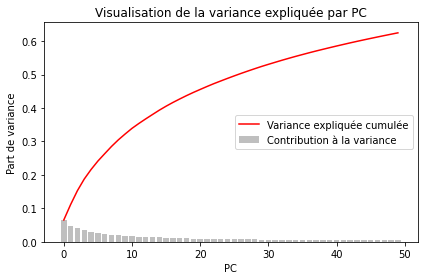

In [30]:
# Contribution des valeurs propres
exp_var_pca = pca_f.explainedVariance.toArray()

# Somme cumulée des valeurs propres
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Visualisation
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, color='grey', align='center', label='Contribution à la variance')
plt.plot(cum_sum_eigenvalues, c='red', label='Variance expliquée cumulée')
plt.ylabel("Part de variance")
plt.xlabel("PC")
plt.legend(loc='center right')
plt.title("Visualisation de la variance expliquée par PC")
plt.tight_layout()
plt.show()

In [31]:
print(f"Les PC retenues permettent d'expliquer {cum_sum_eigenvalues[-1]:.0%} de la variance totale de l'échantillon.")

Les PC retenues permettent d'expliquer 62% de la variance totale de l'échantillon.
